In [1]:
from scipy.stats import norm
import numpy as np
from stochoptim.scengen.scenario_tree import ScenarioTree
from stochoptim.scengen.scenario_process import ScenarioProcess
from stochoptim.scengen.variability_process import VariabilityProcess 
from stochoptim.scengen.figure_of_demerit import FigureOfDemerit 
from stochoptim.scengen.tree_search import TreeSearch

We illustrate on a Geometric Brownian Motion (GBM) the first one of the two methods to build scenario trees with **optimized scenarios and structure**.  

This method consists in exploring the space of tree structures (either exhaustively or heuristically) in order to find the one  minimizing the figure of demerit. It has the advantage of offering a diversity of structures. However, it becomes impractical when the number of stages and scenarios is large.

# Define a `ScenarioProcess` instance for the GBM

In [2]:
S_0 = 2 # initial value (at stage 0)
delta_t = 1 # time lag between 2 stages
mu = 0 # drift
sigma = 1 # volatility

The `gbm_recurrence` function below implements the dynamic relation of a GBM:  
* $S_{t} = S_{t-1} \exp[(\mu - \sigma^2/2) \Delta t + \sigma  \epsilon_t\sqrt{\Delta t}], \quad t=1,2,\dots$  

where $\epsilon_t$ is a standard normal random variable $N(0,1)$.

The discretization of $\epsilon_t$ is done by quasi-Monte Carlo (QMC) and is implemented by the `epsilon_sample_qmc` method.

In [3]:
def gbm_recurrence(stage, epsilon, scenario_path):
    if stage == 0:
        return {'S': np.array([S_0])}
    else:
        return {'S': scenario_path[stage-1]['S'] \
                        * np.exp((mu - sigma**2 / 2) * delta_t + sigma * np.sqrt(delta_t) * epsilon)}
    
def epsilon_sample_qmc(n_samples, stage, u=0.5):
    return norm.ppf(np.linspace(0, 1-1/n_samples, n_samples) + u / n_samples).reshape(-1, 1)

scenario_process = ScenarioProcess(gbm_recurrence, epsilon_sample_qmc)

# Define a `VariabilityProcess` instance

In [4]:
def lookback_fct(stage, scenario_path):
    return scenario_path[stage]['S'][0]

def looknow_fct(stage, epsilon):
    return np.exp(epsilon[0])

my_variability = VariabilityProcess(lookback_fct, looknow_fct)

# Define a `FigureOfDemerit` instance

In [5]:
def demerit_fct(stage, epsilons, weights):
    return 1 / len(epsilons)

my_demerit = FigureOfDemerit(demerit_fct, my_variability)

# Define a `TreeSearch` instance

In [6]:
tree_search = TreeSearch(scenario_process, my_variability, my_demerit, nber_stages=5)

### Exhaustive search

In [7]:
tree_search.exhaustive_search(nber_scenarios=20, optimized='backward', max_iteration=3000)

iteration: 3000  demerit: 3.03244  best demerit: 2.76647  no improvement count: 2886
Total number of iterations : 3000 (14.2 sec)


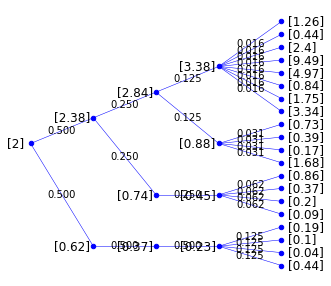

In [8]:
tree_search.best_tree(("EXH", 'backward')).plot('S')

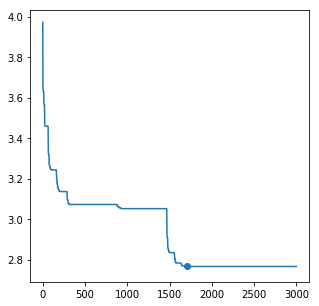

In [9]:
tree_search.plot_fod_progress(("EXH", 'backward'))

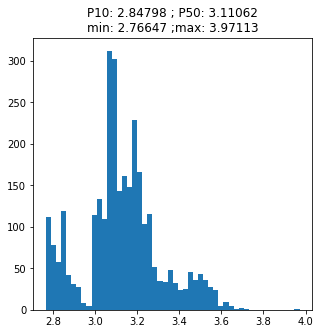

In [10]:
tree_search.plot_fod_hist(bins=50, method=("EXH", 'backward'))

### Variable Neighborhood Search

In [11]:
tree_search.variable_neighborhood_search(nber_scenarios=20, optimized='forward', max_iteration=100)

iteration: 100  demerit: 2.87587  best demerit: 2.43382  no improvement count: 51
Total number of iterations : 100 (65.3 sec)


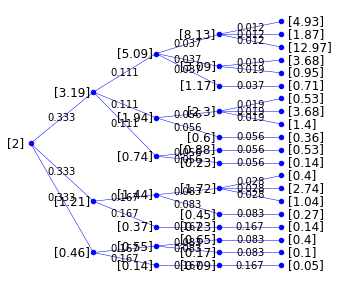

In [12]:
tree_search.best_tree(("VNS", "forward")).plot('S')

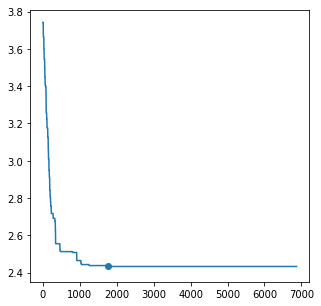

In [13]:
tree_search.plot_fod_progress(("VNS", "forward"))

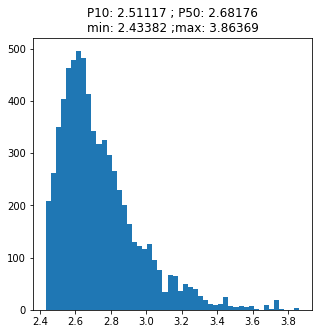

In [15]:
tree_search.plot_fod_hist(bins=50, method=("VNS", "forward"))